In [27]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv('Combined Data.csv', index_col=0)

### Removing missing data

In [29]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [30]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

In [31]:
df.status.value_counts()

Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: status, dtype: int64

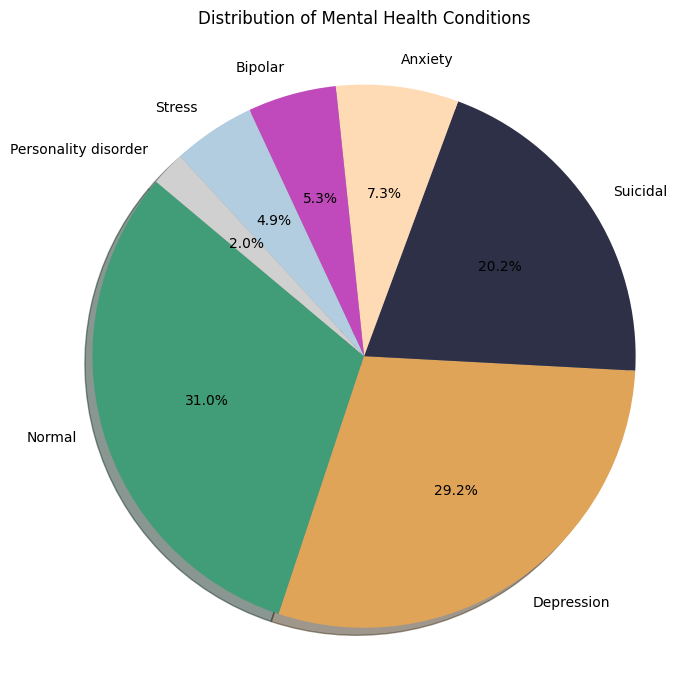

In [32]:
status_counts = df['status'].value_counts()
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']


plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal') 

plt.tight_layout()
plt.show()

The data has a class imbalance

### Adding new features

In [33]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


### Text pre-processing

#### Lowercasing 

Convert all statements to lowercase to ensure uniformity.

In [34]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()

#### Removing URLs, handles, punctuation and special characters

In [35]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)

#### Tokenization

Split text into individual words or tokens.

In [36]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)

#### Stemming

Reduce words to their base or root form. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, **happi** and **sunni**. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

- happy
- happiness
- happier

We can see that the prefix **happi** is more commonly used. We cannot choose **happ** because it is the stem of unrelated words like **happen**.

In [37]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

#### Word Clouds

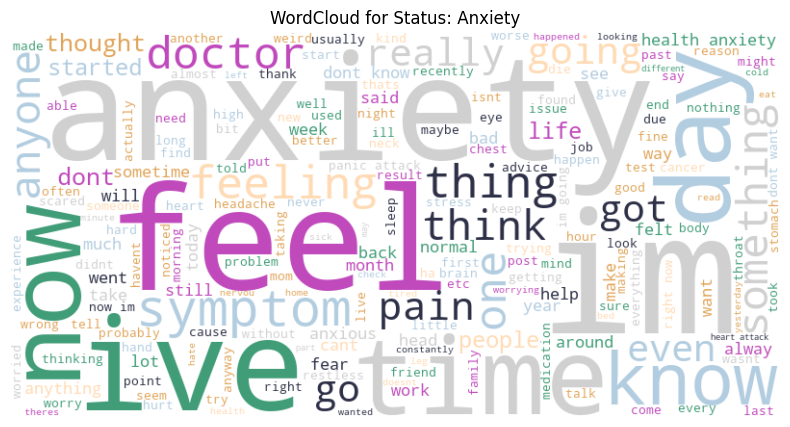

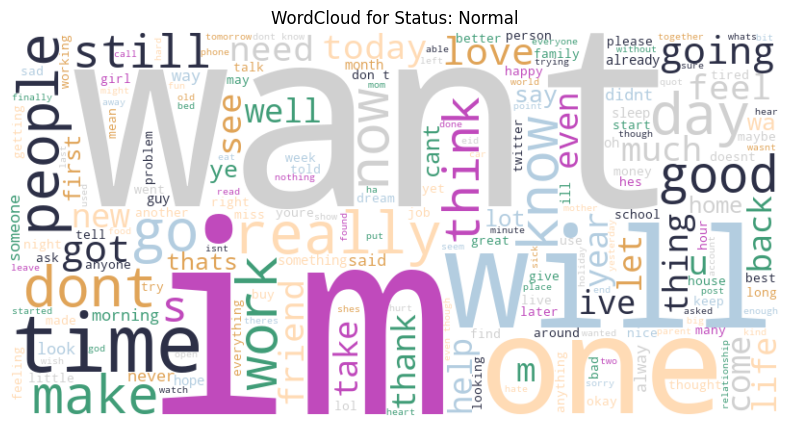

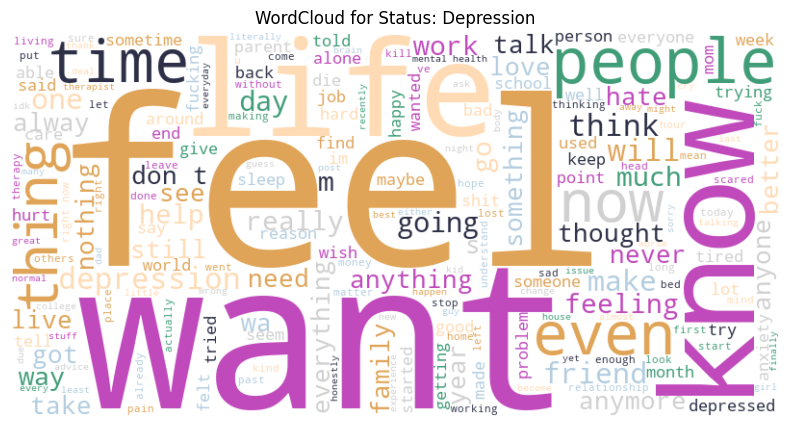

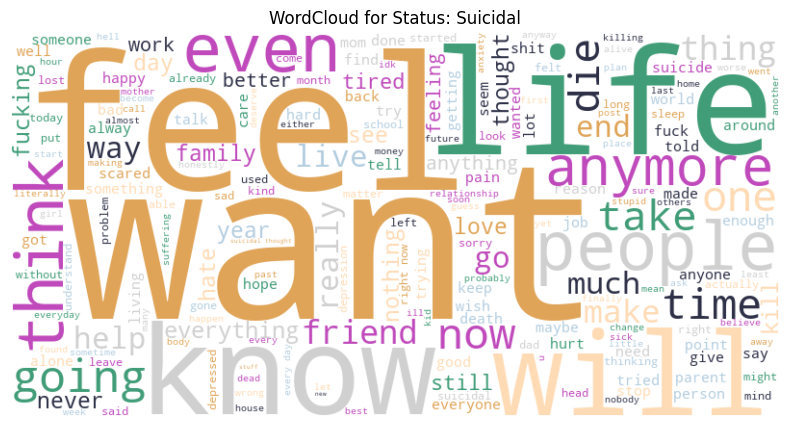

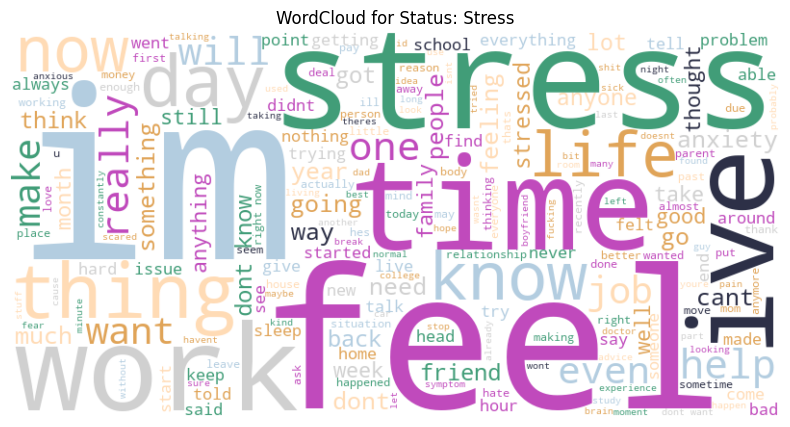

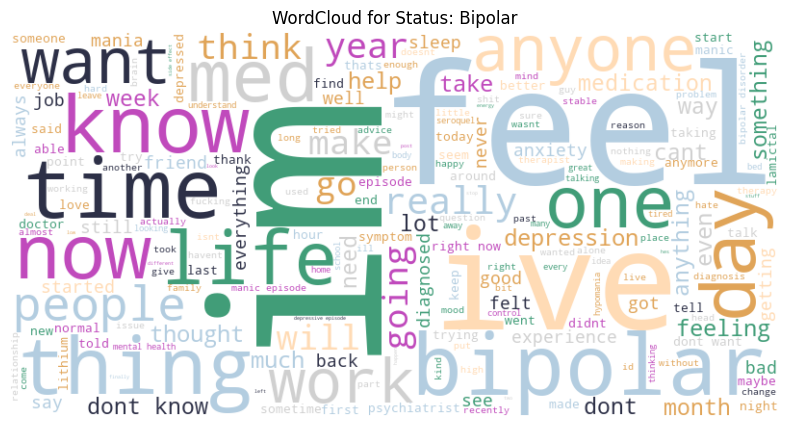

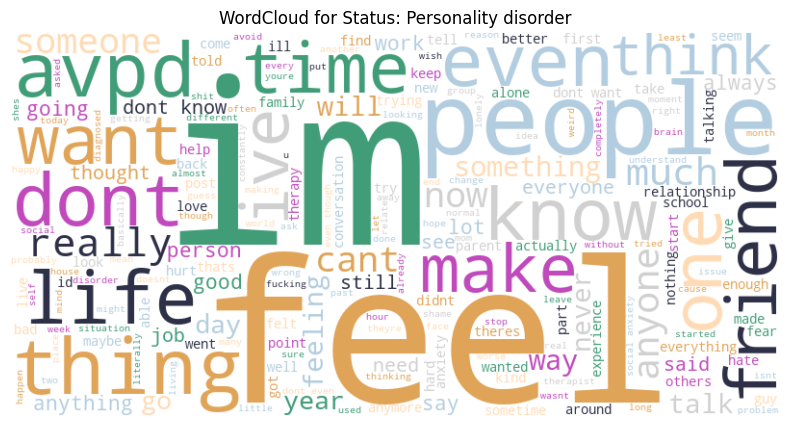

In [13]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [39]:
df.columns

Index(['original_statement', 'status', 'num_of_characters', 'num_of_sentences',
       'statement', 'tokens', 'tokens_stemmed'],
      dtype='object')

#### Separate features and labels

In [41]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemma(text):
    words = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w.lower(), pos='v') for w in words])

df.statement = df.statement.apply(lambda x: lemma(x))

In [40]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

#### Label encoding target variable

In [15]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

#### Split the data into training and testing sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

#### Convert text to features using TF-IDF vectoriser

In [17]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [18]:
X_train_combined.shape

(42144, 50002)

#### Resampling

In [19]:
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [20]:
X_train_resampled.shape

(91742, 50002)

## Model training

In [21]:
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')
}



For Bernoulli Naive Bayes
Accuracy: 0.6405997912119199
                      precision    recall  f1-score   support

             Anxiety       0.67      0.60      0.63       768
             Bipolar       0.70      0.58      0.64       566
          Depression       0.66      0.48      0.55      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.87      0.33      0.48       202
              Stress       0.42      0.52      0.47       530
            Suicidal       0.59      0.53      0.56      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



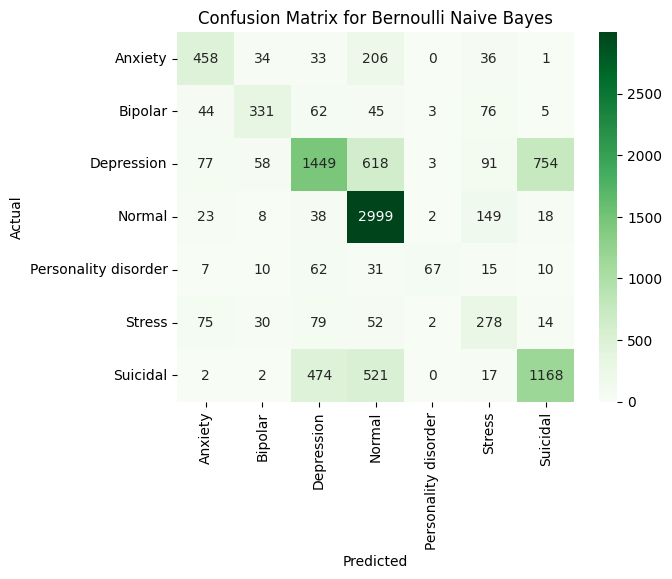



For Decision Tree
Accuracy: 0.6175381987282907
                      precision    recall  f1-score   support

             Anxiety       0.69      0.55      0.61       768
             Bipolar       0.46      0.63      0.53       566
          Depression       0.79      0.34      0.48      3050
              Normal       0.87      0.85      0.86      3237
Personality disorder       0.51      0.47      0.48       202
              Stress       0.24      0.80      0.37       530
            Suicidal       0.52      0.65      0.58      2184

            accuracy                           0.62     10537
           macro avg       0.58      0.61      0.56     10537
        weighted avg       0.70      0.62      0.62     10537



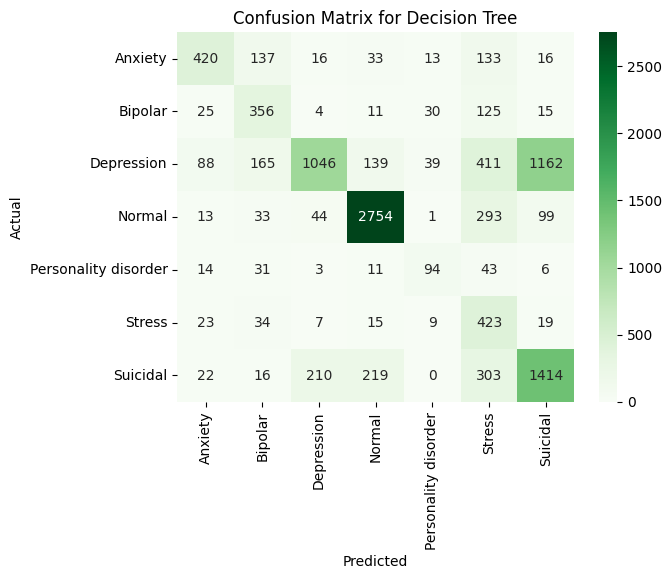



For Logistic Regression
Accuracy: 0.7653981209072791
                      precision    recall  f1-score   support

             Anxiety       0.78      0.81      0.80       768
             Bipolar       0.84      0.80      0.82       566
          Depression       0.72      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.71      0.64      0.68       202
              Stress       0.59      0.65      0.62       530
            Suicidal       0.65      0.68      0.67      2184

            accuracy                           0.77     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.77      0.77      0.76     10537



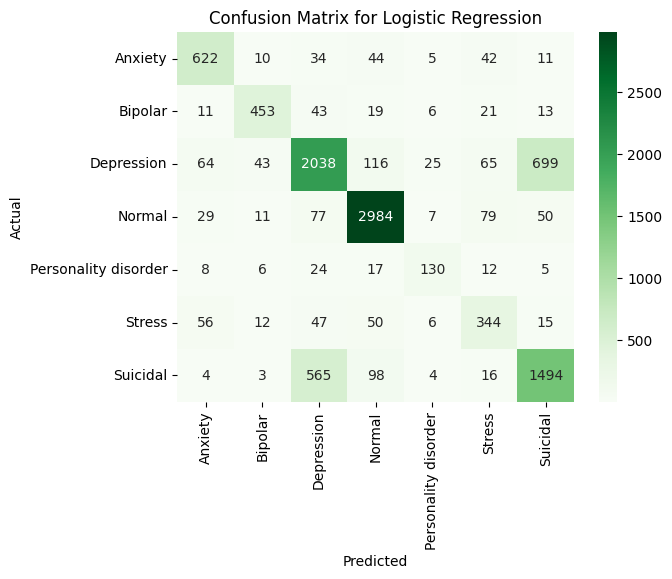



For XGB
Accuracy: 0.8069659295814748
                      precision    recall  f1-score   support

             Anxiety       0.83      0.87      0.85       768
             Bipolar       0.88      0.82      0.85       566
          Depression       0.78      0.72      0.75      3050
              Normal       0.92      0.94      0.93      3237
Personality disorder       0.85      0.66      0.74       202
              Stress       0.67      0.76      0.71       530
            Suicidal       0.69      0.73      0.71      2184

            accuracy                           0.81     10537
           macro avg       0.80      0.79      0.79     10537
        weighted avg       0.81      0.81      0.81     10537



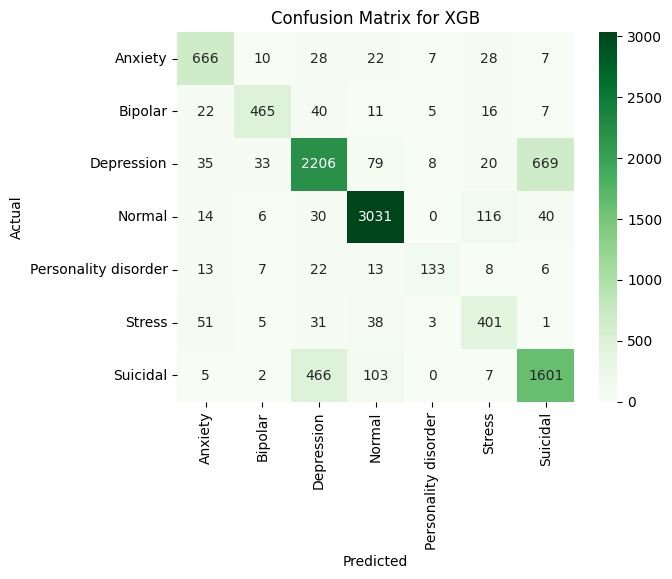

In [22]:
accuracy_scores = []

for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap
    
    accuracy_scores.append(accuracy)

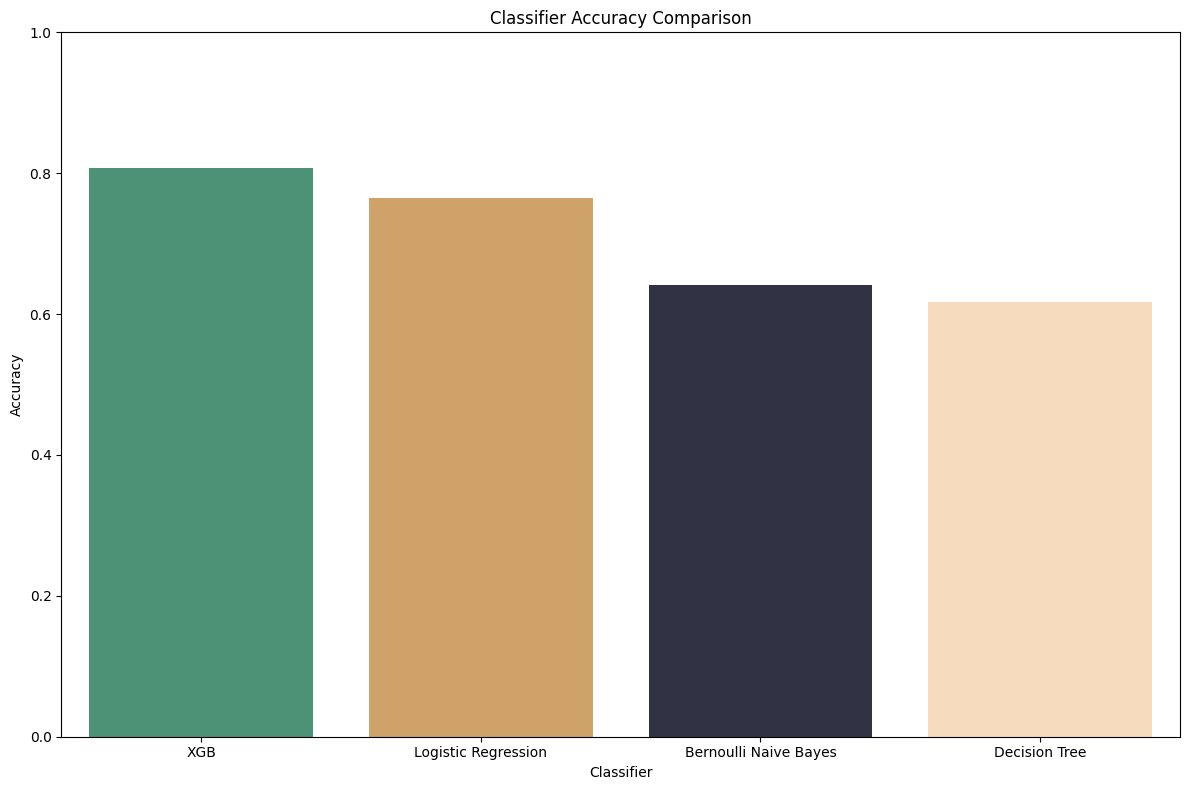

In [23]:
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))


sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)
plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()